In [46]:
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns # I love this package!
sns.set_style('white')

import torch

### Loss Trend Check

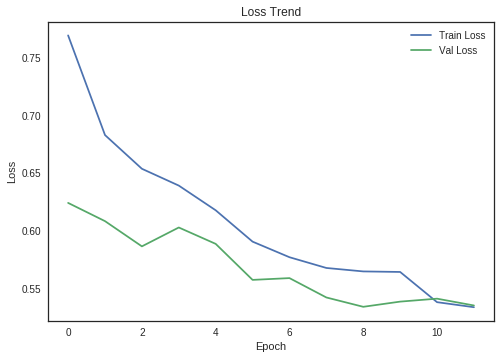

In [47]:
# load check point
model_path = 'checkpoint.pth.tar'
checkpoint = torch.load(model_path)
loss_history_train = checkpoint['loss_history_train']
loss_history_val = checkpoint['loss_history_val']
loss_train = [np.mean(l) for l in loss_history_train]
loss_val = [np.mean(l) for l in loss_history_val]
plt.plot(loss_train, label = 'Train Loss')
plt.plot(loss_val, label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

### model performance

In [48]:
model_path = 'model_best.pth.tar'
# calculate outputs for the test data with our best model
output_csv_path = 'pred.csv'
command = ('python pred.py '
           '--img_dir /home/dhwon/data_hdd2/UCLA-protest/img/test/ '
           '--output_csvpath {csv_path} '
           '--model {model} --batch_size 4 --cuda'
           .format(csv_path = output_csv_path, model = model_path))

            
!{command}

# load prediction
df_pred = pd.read_csv(output_csv_path)
df_pred['imgpath'] = df_pred['imgpath'].apply(os.path.basename)

# load target
test_label_path = '/home/dhwon/data_hdd2/UCLA-protest/annot_test.txt'
df_target = pd.read_csv(test_label_path, delimiter= '\t')

*** loading model from model_best.pth.tar
*** calculating the model output of the images in /home/dhwon/data_hdd2/UCLA-protest/img/test/
100%|██████████████████████████████████████| 8153/8153 [00:55<00:00, 145.70it/s]


#### Binary Variables

In [49]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
def plot_roc(attr, target, pred):
    """Plot a ROC curve and show the accuracy score and the AUC"""
    auc = roc_auc_score(target, pred)
    acc = accuracy_score(target, (pred >= 0.5).astype(int))
    fpr, tpr, _ = roc_curve(target, pred)
    plt.plot(fpr, tpr, lw = 2, label = attr.title())
    plt.legend()
    plt.title(('ROC Curve for {attr} (Accuracy = {acc:.3f}, AUC = {auc:.3f})'
               .format(attr = attr.title(), acc= acc, auc = auc)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()


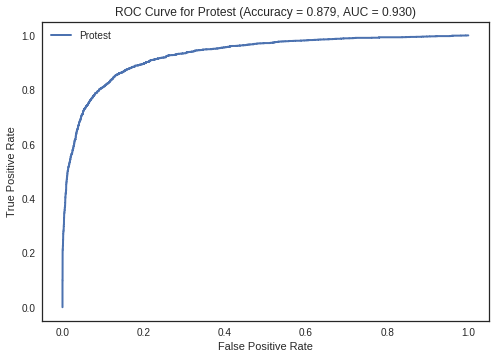

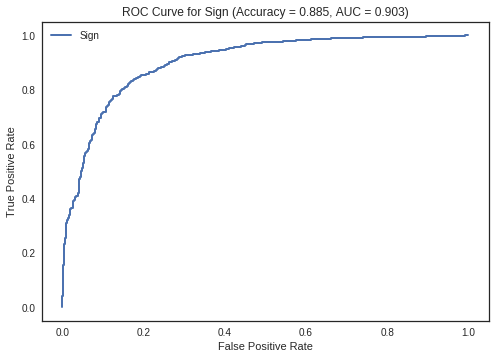

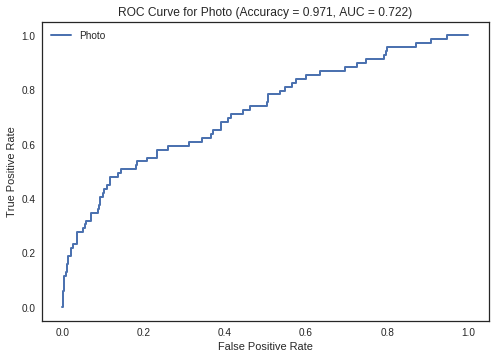

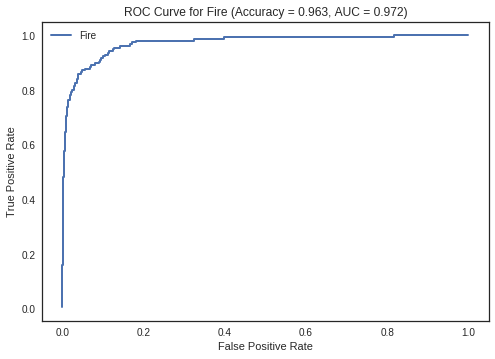

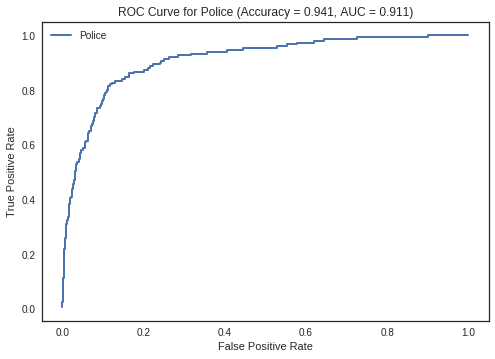

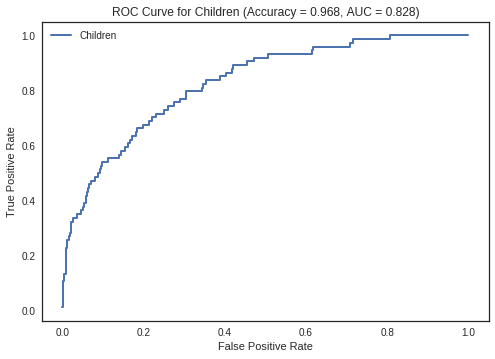

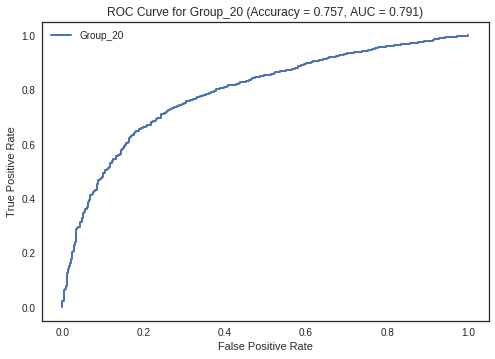

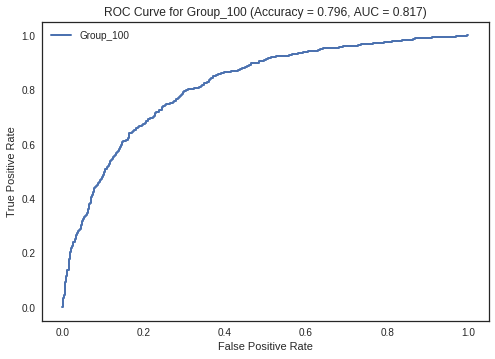

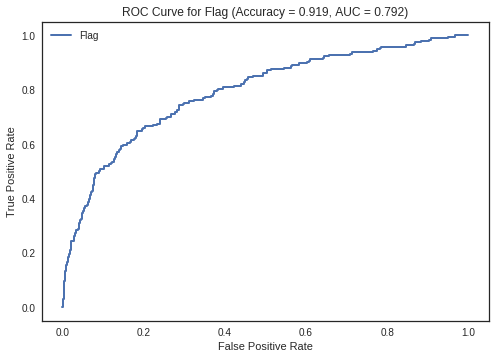

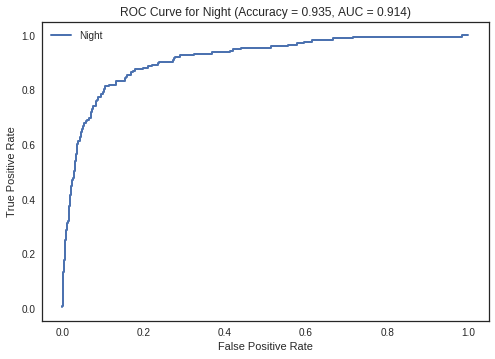

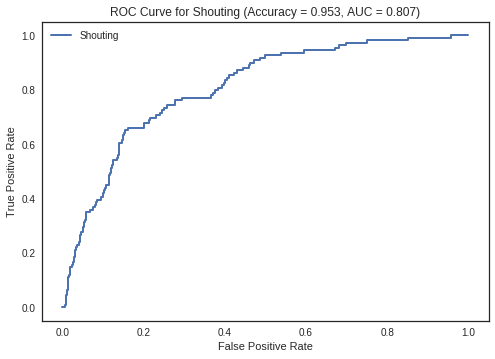

In [50]:
# plot ROC curve for protest
attr = "protest"
target = df_target[attr]
pred = df_pred[attr]
plot_roc(attr, target, pred)
# plot ROC curves for visual attributes
for attr in df_pred.columns[3:]:
    target = df_target[attr]
    pred = df_pred[attr][target != '-']
    target = target[target != '-'].astype(int)
    plot_roc(attr, target, pred)

#### Violence

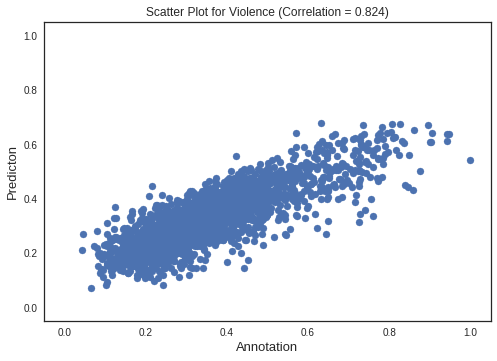

In [52]:
import scipy.stats as stats
attr = 'violence'
pred = df_pred[df_target['protest'] == 1][attr].tolist()
target = df_target[df_target['protest'] == 1][attr].astype(float).tolist()
plt.scatter(target, pred, label = attr.title())
plt.xlim([-.05,1.05])
plt.ylim([-.05,1.05])
plt.xlabel('Annotation', fontsize = 13)
plt.ylabel('Predicton', fontsize = 13)
corr, pval = stats.pearsonr(target, pred)
plt.title(('Scatter Plot for {attr} (Correlation = {corr:.3f})'
            .format(attr = attr.title(), corr= corr)))
plt.show()